In [1]:
# Import some useful modules
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import re
from sklearn import ensemble
from sklearn import metrics
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Load the file as dataframe
file_path = '/Users/chuanlong/GitHub/Tandon_Torch/data/train.json'
df = pd.read_json(file_path);

In [3]:
# This Method include the pipeline to clean the dataset
def clean_data(df):
    # Filter the building id outlier
    outlier_filter_buildingid = (df.building_id != '0')
    df = df[outlier_filter_buildingid]
    # Filter the price outlier
    outlier_filter_price = (500 < df.price) & (df.price < 8000)
    df = df[outlier_filter_price]
    # Filter the null listing id
    df = df[df.listing_id.isnull() == False]
    # Filter the position outlier
    outlier_filter_longitude = (df.longitude > -74.2) & (df.longitude < -73.6)
    df = df[outlier_filter_longitude]
    outlier_filter_latitude = (df.latitude > 40.0) & (df.latitude < 41.0) 
    df = df[outlier_filter_latitude]
    return df

In [4]:
# This method transform the Created timeframe to days
def transformCreatedTime(df, attribute):
    current_time = pd.to_datetime('2017-01-01')
    df[attribute] = df[attribute].map(lambda x : current_time - pd.to_datetime(x))\
                                 .map(lambda x : x / np.timedelta64(1, 's'))\
                                 .map(lambda x : float(x) / (60 * 60 * 24))
    return df[attribute]

In [5]:
def create_features(df):
    def word_stem(s):
        if type(s) == str:
            s = s.lower()
            s = s.strip()
            s = s.replace('/', ' ')
            s = s.replace(':', ' ')
            s = s.replace('&', ' ')
            s = s.replace('-', ' ')
            s = re.sub(r'[!]+', '', s)
            return s
        else:
            return None
    def list_stem(features):
        if len(features) > 0:
            s = ''
            for i in range(len(features)):
                features[i] = word_stem(features[i])
                s += ' ' + features[i]
            return s
        else:
            return ''
    df['features'] = df['features'].map(lambda x: list_stem(x))
    df['doorman'] = df['features'].map(lambda x: 1 if 'doorman' in x else 0)
    df['elevator'] = df['features'].map(lambda x: 1 if 'elevator' in x else 0)
    df['laundry'] = df['features'].map(lambda x: 1 if 'laundry' in x else 0)
    df['hardwood'] = df['features'].map(lambda x: 1 if 'hardwood' in x else 0)
    df['fitness'] = df['features'].map(lambda x: 1 if 'fitness' in x else 0)
    df['pets'] = df['features'].map(lambda x: 1 if 'cats' in x or 'dogs'in x else 0)
    df['dishwasher'] = df['features'].map(lambda x: 1 if 'dishwasher' in x else 0)
    df['no_fee'] = df['features'].map(lambda x: 1 if 'no fee' in x else 0)
    df['weighted_features'] = df.doorman * 0.12 + df.elevator * 0.15\
                            + df.laundry * 0.16 + df.hardwood * 0.16\
                            + df.fitness * 0.1 + df.pets * 0.22\
                            + df.dishwasher * 0.16 + df.no_fee * 0.22
    return df

In [6]:
# This method is to preprocess the dataset, you will all set if you call it
def preprocess_data(df):
    df = clean_data(df)
    df.created = transformCreatedTime(df, 'created')
    df = create_features(df)
    return df

In [7]:
df = preprocess_data(df)
df

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,street_address,doorman,elevator,laundry,hardwood,fitness,pets,dishwasher,no_fee,weighted_features
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,190.670556,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,medium,40.7145,7211212,...,792 Metropolitan Avenue,0,0,0,0,0,0,0,0,0.00
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,202.486493,,Columbus Avenue,doorman elevator fitness center cats allowed ...,low,40.7947,7150865,...,808 Columbus Avenue,1,1,0,0,1,1,0,0,0.59
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,258.856470,"Top Top West Village location, beautiful Pre-w...",W 13 Street,laundry in building dishwasher hardwood floor...,high,40.7388,6887163,...,241 W 13 Street,0,0,1,1,0,0,1,0,0.48
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,257.901366,Building Amenities - Garage - Garden - fitness...,East 49th Street,hardwood floors no fee,low,40.7539,6888711,...,333 East 49th Street,0,0,0,1,0,0,0,1,0.38
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,256.816123,,West 18th Street,,medium,40.7429,6894514,...,350 West 18th Street,0,0,0,0,0,0,0,0,0.00
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,248.861157,Stunning unit with a great location and lots o...,West 107th Street,prewar elevator dogs allowed cats allowed low...,low,40.8012,6930771,...,210 West 107th Street,0,1,0,1,0,1,0,1,0.75
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,262.748819,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,doorman elevator pre war terrace laundry in u...,low,40.7427,6867392,...,155 West 21st Street,1,1,1,1,0,0,1,0,0.75
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,255.891262,<p><a website_redacted,Hamilton Terrace,cats allowed dogs allowed elevator laundry in...,medium,40.8234,6898799,...,63 Hamilton Terrace,0,1,1,0,0,1,0,0,0.53
100044,1.0,2,67c9b420da4a365bc26a6cd0ef4a5320,256.765683,***LOW FEE. Beautiful CHERRY OAK WOODEN FLOORS...,E 38th St,doorman elevator laundry in building no fee,high,40.7488,6895442,...,137 E 38th St,1,1,1,0,0,0,0,1,0.65
100051,1.0,0,bfb9405149bfff42a92980b594c28234,257.891667,Stunning full renovated studio unit. High cei...,East 34th Street,doorman elevator fitness center laundry in bu...,medium,40.7439,6889043,...,340 East 34th Street,1,1,1,0,1,0,0,1,0.75


In [8]:
# Preprocess the train dataset
# columns = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created', 'doorman', 'elevator', 'laundry', 'hardwood', 'fitness', 'pets', 'dishwasher', 'no_fee', 'interest_level']
columns = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created', 'weighted_features', 'interest_level']
# df = preprocess_data(df)
data = df[columns]
X, y = data.drop('interest_level', 1), data.interest_level
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

### Feature Engineering Experiment

#### Feature Importances without weighted_features

In [36]:
old_columns = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'created', 'doorman', 'elevator', 'laundry', 'hardwood', 'fitness', 'pets', 'dishwasher', 'no_fee', 'interest_level']
pre_train_data = df[old_columns]
pre_train_data

,bathrooms,bedrooms,latitude,longitude,price,created,doorman,elevator,laundry,hardwood,fitness,pets,dishwasher,no_fee,interest_level
10,1.5,3,40.7145,-73.9425,3000,190.670556,0,0,0,0,0,0,0,0,medium
10000,1.0,2,40.7947,-73.9667,5465,202.486493,1,1,0,0,1,1,0,0,low
100004,1.0,1,40.7388,-74.0018,2850,258.856470,0,0,1,1,0,0,1,0,high
100007,1.0,1,40.7539,-73.9677,3275,257.901366,0,0,0,1,0,0,0,1,low
100014,2.0,4,40.7429,-74.0028,7995,256.816123,0,0,0,0,0,0,0,0,medium
100016,1.0,2,40.8012,-73.9660,3600,248.861157,0,1,0,1,0,1,0,1,low
100020,2.0,1,40.7427,-73.9957,5645,262.748819,1,1,1,1,0,0,1,0,low
100026,1.0,1,40.8234,-73.9457,1725,255.891262,0,1,1,0,0,1,0,0,medium
100044,1.0,2,40.7488,-73.9770,3000,256.765683,1,1,1,0,0,0,0,1,high
100051,1.0,0,40.7439,-73.9743,2350,257.891667,1,1,1,0,1,0,0,1,medium


In [37]:
pre_random_forest = RandomForestClassifier(n_estimators=250, random_state=0)
X, y = pre_train_data.drop('interest_level', 1), train_data.interest_level
pre_random_forest.fit(X, y)
importances = pre_random_forest.feature_importances_

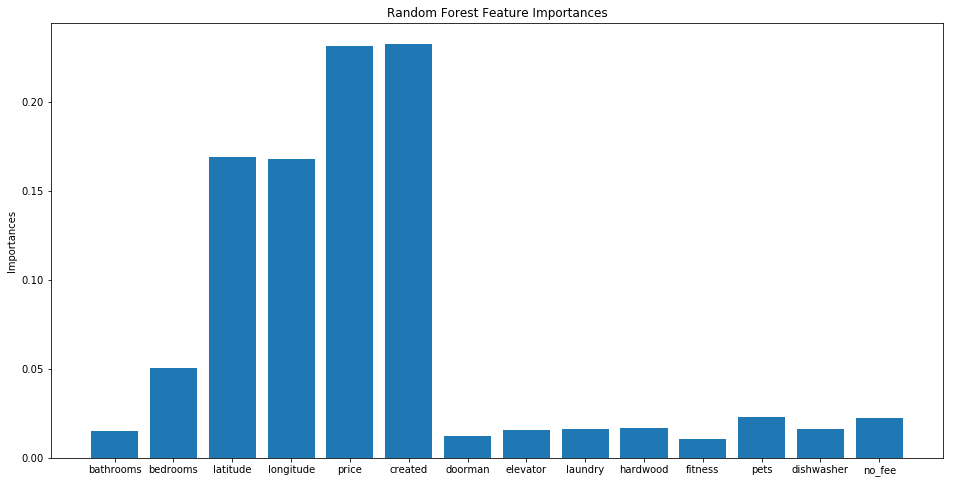

In [39]:
# Plot the Picture for the feature importances
plt.figure(figsize=(16,8))
plt.bar(np.arange(14), pre_random_forest.feature_importances_)
plt.xticks(np.arange(14), old_columns)
plt.ylabel('Importances')
plt.title('Random Forest Feature Importances')
plt.show()

#### Feature Importances with weighted_features

In [27]:
extra_trees = ExtraTreesClassifier(n_estimators=250, random_state=0)
X, y = train_data.drop('interest_level', 1), train_data.interest_level
extra_trees.fit(X, y)
importances = extra_trees.feature_importances_

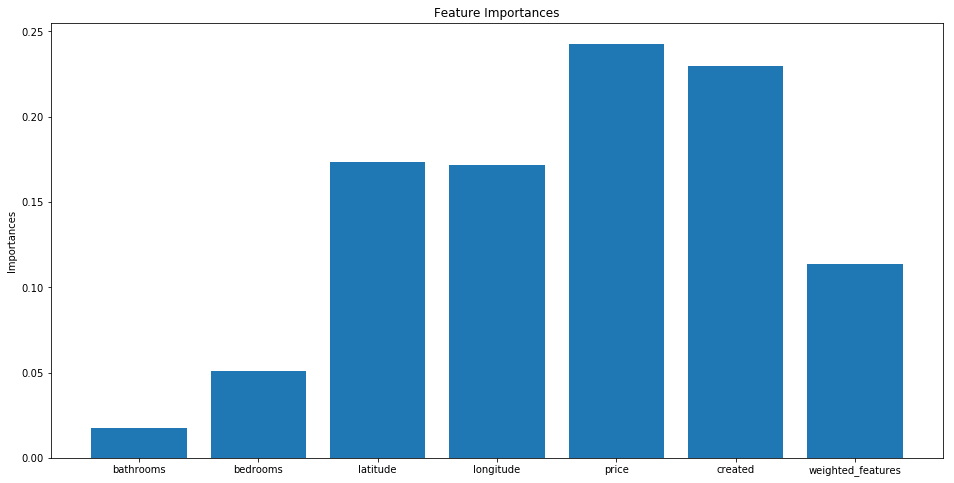

In [30]:
# Plot the Picture for the feature importances
plt.figure(figsize=(16,8))
plt.bar(np.arange(7), extra_trees.feature_importances_)
plt.xticks(np.arange(7), columns)
plt.ylabel('Importances')
plt.title('Extra Trees Feature Importances')
plt.show()

In [32]:
random_forest = RandomForestClassifier(n_estimators=250, random_state=0)
X, y = train_data.drop('interest_level', 1), train_data.interest_level
random_forest.fit(X, y)
importances = random_forest.feature_importances_

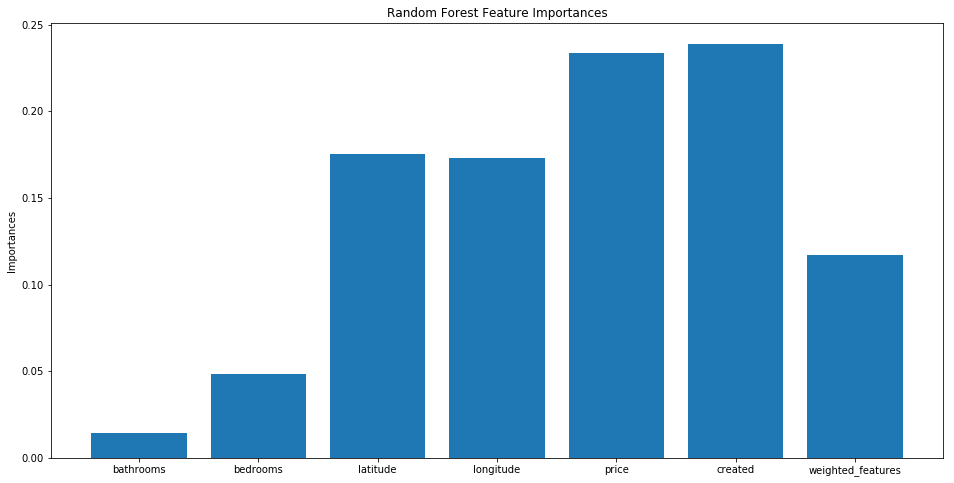

In [33]:
# Plot the Picture for the feature importances
plt.figure(figsize=(16,8))
plt.bar(np.arange(7), random_forest.feature_importances_)
plt.xticks(np.arange(7), columns)
plt.ylabel('Importances')
plt.title('Random Forest Feature Importances')
plt.show()

### Model Training

* Should use the grid search
* Should test other models
* How could you measure the training progress?

In [129]:
def log_loss_score(true_label, predict_label):
    return metrics.log_loss(true_label, predict_label)

In [130]:
def train_model(X_train, X_test, y_train, y_test, params):
    # Should use the grid search
    clf = ensemble.GradientBoostingClassifier(**params)
    clf = clf.fit(X_train, y_train)
    res = clf.predict_proba(X_test)
    score = metrics.log_loss(y_test, res)
    return score

In [131]:
def grid_search_paramaters(X_train, y_train, params_grid):
    gbc_grid_search = GridSearchCV(ensemble.GradientBoostingClassifier(), params_grid, scoring = 'log_loss')
    gbc_grid_search.fit(X_train, y_train)
    return gbc_grid_search.best_estimator_

### GridSearch Experiment

In [132]:
params_grid = {'n_estimators': [100, 250], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [450, 600, 750], 'min_samples_leaf' : [1, 2, 3], 'learning_rate': [0.1, 1.0], 'loss': ['deviance']}

In [133]:
gbc_grid_search = GridSearchCV(ensemble.GradientBoostingClassifier(), params_grid, scoring = 'log_loss') 
gbc_grid_search.fit(X_train, y_train)

/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metric

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 250], 'max_depth': [4, 5, 6, 7, 8], 'min_samples_split': [450, 600, 750], 'min_samples_leaf': [1, 2, 3], 'learning_rate': [0.1, 1.0], 'loss': ['deviance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [134]:
gbc_grid_search.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=3,
              min_samples_split=600, min_weight_fraction_leaf=0.0,
              n_estimators=250, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [52]:
params_grid = {'n_estimators': [100, 500], 'max_depth': [4, 8], 'min_samples_split': [4, 8], 'learning_rate': [0.1, 1.0], 'loss': ['deviance']}

In [53]:
gbc_grid_search = GridSearchCV(ensemble.GradientBoostingClassifier(), params_grid, scoring = 'log_loss') 
gbc_grid_search.fit(X_train, y_train)

/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/chuanlong/anaconda/lib/python3.6/site-packages/sklearn/metric

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 500], 'max_depth': [4, 8], 'min_samples_split': [4, 8], 'learning_rate': [0.1, 1.0], 'loss': ['deviance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=0)

In [54]:
gbc_grid_search.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=4, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [14]:
# params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split':4,
#           'learning_rate': 0.1, 'loss': 'deviance'}
params = {'n_estimators': 300, 'max_depth': 5, 'min_samples_split':600,
          'learning_rate': 0.1, 'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
score = metrics.log_loss(y_test, y_pred)
score

0.67749635961800647

In [16]:
# Plot Training Deviance
# compute test set deviance
test_score = np.zeros((params['n_estimators'], ), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict_proba(X_test)):
    test_score[i] = metrics.log_loss(y_test, y_pred)

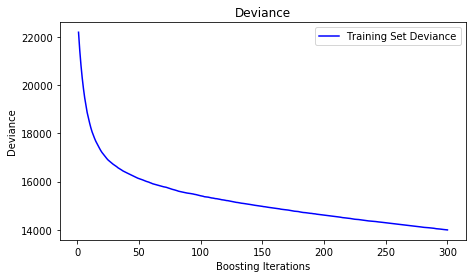

In [19]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-', label='Training Set Deviance')
# plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

In [73]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split':50,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69851948783517759

In [74]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split':50,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69350787301556704

In [75]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split':50,
          'learning_rate': 0.01, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.7132821487152643

In [76]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split':50,
          'learning_rate': 1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

1.0364229023528495

In [77]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split':50,
          'learning_rate': 1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.79181764010070566

In [78]:
params = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split':2,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69811696726819106

In [79]:
params = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69827389583693156

In [80]:
params = {'n_estimators': 500, 'max_depth': 8, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.79106582604882381

In [81]:
params = {'n_estimators': 50, 'max_depth': 8, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69593394365506356

In [82]:
params = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

1.4497375798167647

In [83]:
params = {'n_estimators': 25, 'max_depth': 8, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.70753278586128054

In [85]:
params = {'n_estimators': 50, 'max_depth': 8, 'min_samples_split':4, 'min_samples_leaf':2, 
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69532259522803508

In [86]:
params = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split':4, 'min_samples_leaf':2, 
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69808208585261877

In [87]:
params = {'n_estimators': 50, 'max_depth': 4, 'min_samples_split':4, 'min_samples_leaf':2, 
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.71227000443326371

In [88]:
params = {'n_estimators': 50, 'max_depth': 16, 'min_samples_split':4, 'min_samples_leaf':2, 
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.88268124774045065

In [89]:
params = {'n_estimators': 50, 'max_depth': 4, 'min_samples_split':8, 'min_samples_leaf':2, 
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.71300162554158475

In [90]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split':50,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.6935082216895786

In [91]:
params = {'n_estimators': 500, 'max_depth': 8, 'min_samples_split':50,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.7419654518998704

In [92]:
params = {'n_estimators': 500, 'max_depth': 3, 'min_samples_split':50,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69223938265269169

In [93]:
params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split':50,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69746699598125528

In [94]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split':50,
          'learning_rate': 1.0, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

1.0363815551581637

In [95]:
params = {'n_estimators': 200, 'max_depth': 4, 'min_samples_split':50,
          'learning_rate': 1.0, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.86408060151133381

In [96]:
params = {'n_estimators': 50, 'max_depth': 4, 'min_samples_split':100,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.71261887694247683

In [97]:
params = {'n_estimators': 50, 'max_depth': 4, 'min_samples_split':20,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.71228824068840602

In [98]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split':100,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69258699237921395

In [99]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split':100,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.70316463174951682

In [101]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.71147597379496308

In [106]:
params = {'n_estimators': 800, 'max_depth': 8, 'min_samples_split':2,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.88753094965236057

In [107]:
params = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split':2,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69994783384075665

In [108]:
params = {'n_estimators': 100, 'max_depth': 16, 'min_samples_split':2,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

1.1665388420805893

In [109]:
params = {'n_estimators': 100, 'max_depth': 12, 'min_samples_split':2,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.79422943670474933

In [110]:
params = {'n_estimators': 100, 'max_depth': 6, 'min_samples_split':2,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69257336641793332

In [111]:
params = {'n_estimators': 100, 'max_depth': 6, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69303397308278158

In [112]:
params = {'n_estimators': 200, 'max_depth': 6, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69580559967751021

In [113]:
params = {'n_estimators': 200, 'max_depth': 6, 'min_samples_split':2,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.69532635456649916

In [114]:
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split':2,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.71904357724758694

In [136]:
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split':4,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.71284136642389784

In [135]:
params = {'n_estimators': 250, 'max_depth': 5, 'min_samples_split':600,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.68162924574488648

In [137]:
params = {'n_estimators': 250, 'max_depth': 5, 'min_samples_split':500,
          'learning_rate': 0.1, 'loss': 'deviance'}
score = train_model(X_train, X_test, y_train, y_test, params)
score

0.68214615797085365